In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# world configuration
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

# robot implementation
class robot:
    def __init__(self):
        # initialise robot with random location and orientation
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * math.pi
        
        self.forward_noise = 0.0
        self.turn_noise    = 0.0
        self.sense_noise   = 0.0
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * math.pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    # measure distance between robot and landmarks
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z

    # apply noisy movement to robot
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (math.cos(orientation) * dist)
        y = self.y + (math.sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        res = robot()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    # model noise using Gaussians
    def Gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
    # calculates how likely a measurement should be for the current location
    def measurement_prob(self, measurement):
        prob = 1.0
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob

In [9]:
# world visualization with the distribution of particles
def show_belief(myrobot, particles):
    plt.rcParams["figure.figsize"] = (5,5)

    for p in particles:
        plt.plot(p.x, p.y, marker=(3, 0, 180.0*p.orientation/math.pi), markerfacecolor='red', markersize=10, markeredgewidth=0.0, alpha=.3, linestyle='None')

    plt.plot(myrobot.x, myrobot.y, marker=(3, 0, 180.0*myrobot.orientation/math.pi), markerfacecolor='black', markersize=20, markeredgewidth=0.0, linestyle='None')

    for x, y in landmarks:
          plt.plot(x, y, marker='o', markerfacecolor='blue', markersize=20, markeredgewidth=0.0, linestyle='None')

    plt.xlim([0,100])
    plt.ylim([0,100])

    plt.show()

# measure the proximity between the real location and the distribution of particles
def eval(r, p):
    s = 0.0;
    for i in range(len(p)):
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = math.sqrt(dx * dx + dy * dy)
        s += err
    return s / float(len(p))

In [15]:
# robot initialization
forward_noise = 3.0 
turn_noise = 0.05
sense_noise = 3.0

myrobot = robot()
myrobot.set_noise(forward_noise, turn_noise, sense_noise)

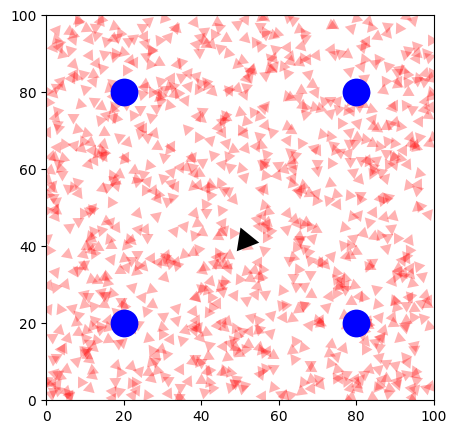

Average distance: 38.98722049984161


In [16]:
# particle distribution
N = 1000 # number of particles
T = 10  # number of moves

# initialise randomly guessed particles
p = []
for i in range(N):
    x = robot()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    p.append(x)

# show initial distribution
show_belief(myrobot, p)
print("Average distance:", eval(myrobot, p))


Turn #1


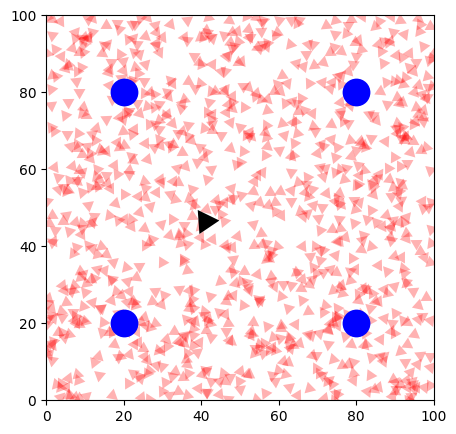

Average distance before resample: 39.295859735161095


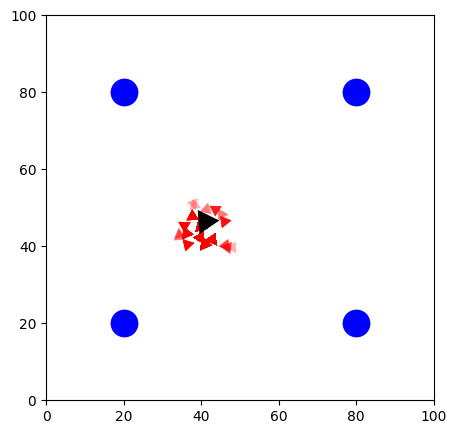

Average distance after resample: 4.15695521873348

Turn #2


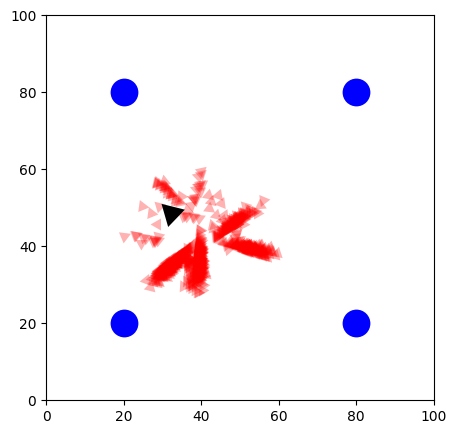

Average distance before resample: 15.517386630677464


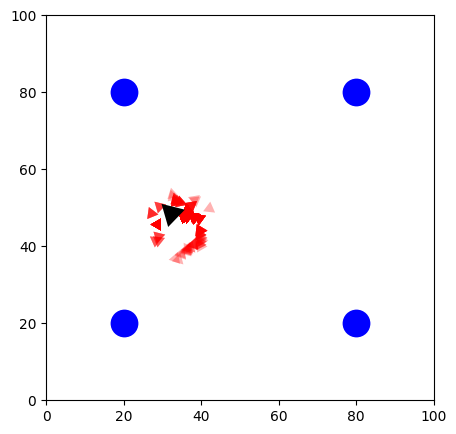

Average distance after resample: 3.8120445079089134

Turn #3


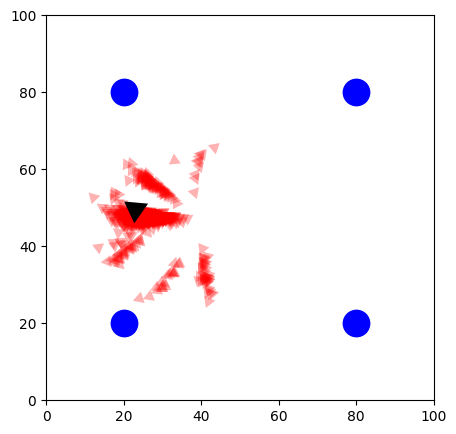

Average distance before resample: 6.1704230842563605


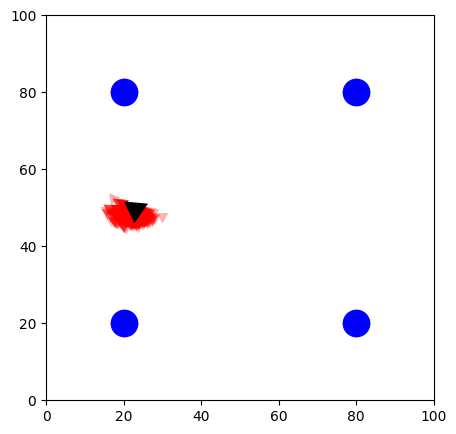

Average distance after resample: 2.5609646577104654

Turn #4


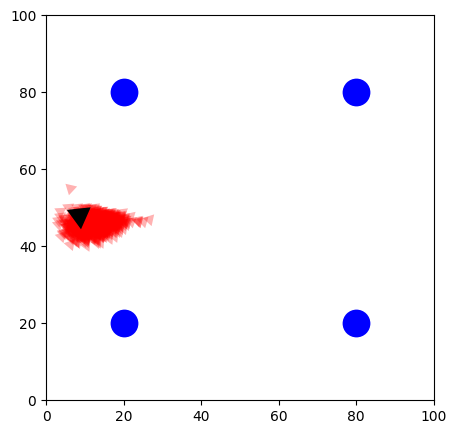

Average distance before resample: 5.152196853971036


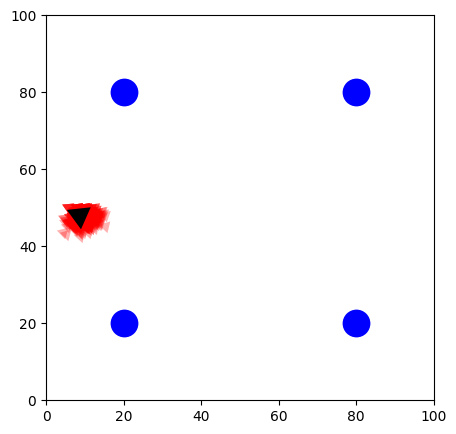

Average distance after resample: 2.070121917608067

Turn #5


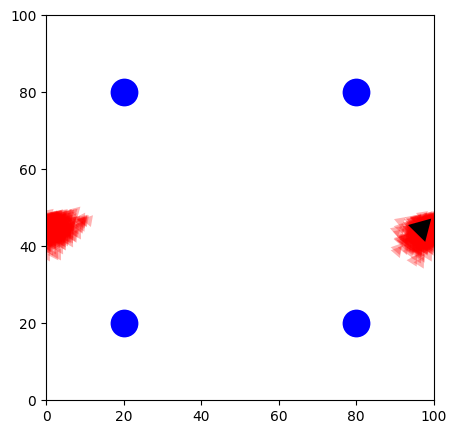

Average distance before resample: 4.531959095125623


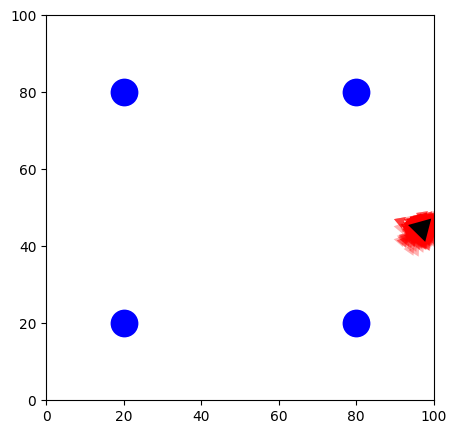

Average distance after resample: 2.050329032990645

Turn #6


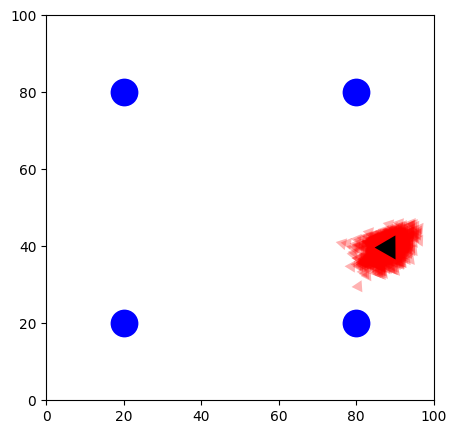

Average distance before resample: 3.5791352839620973


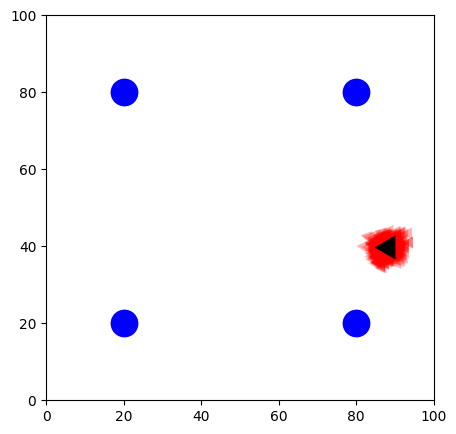

Average distance after resample: 2.1165390645870894

Turn #7


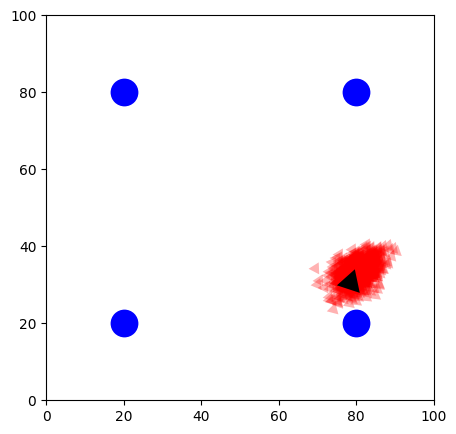

Average distance before resample: 4.5714851161457055


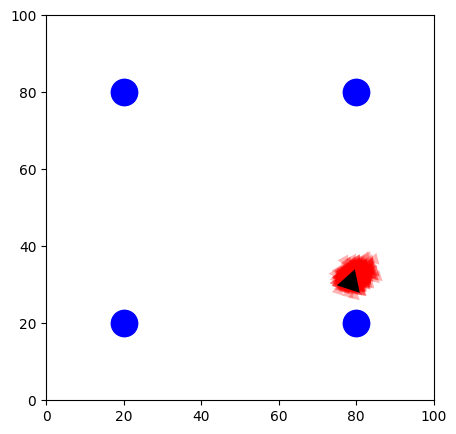

Average distance after resample: 2.8260565909060182

Turn #8


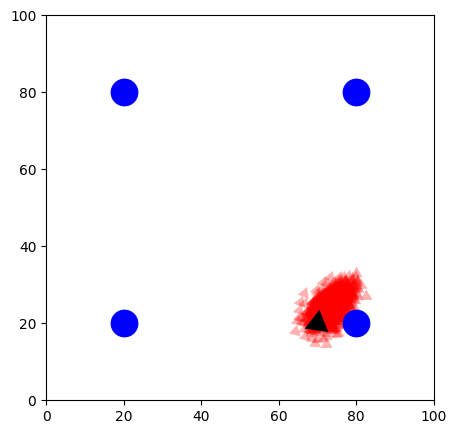

Average distance before resample: 6.557379447603168


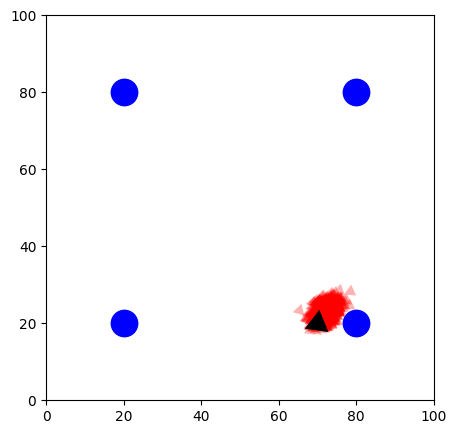

Average distance after resample: 4.322645104508587

Turn #9


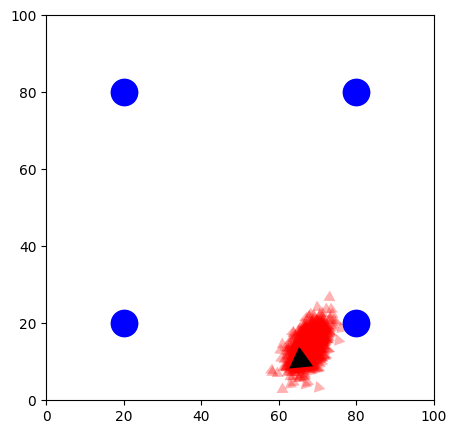

Average distance before resample: 5.458750473530629


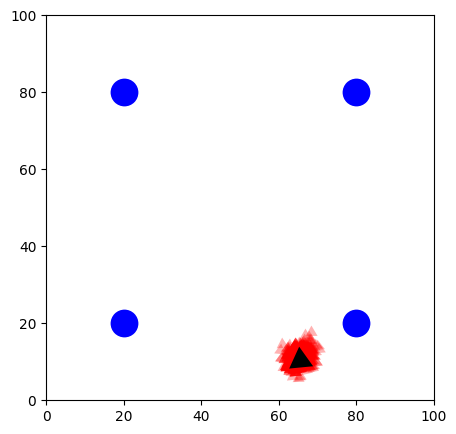

Average distance after resample: 2.3830812087319653

Turn #10


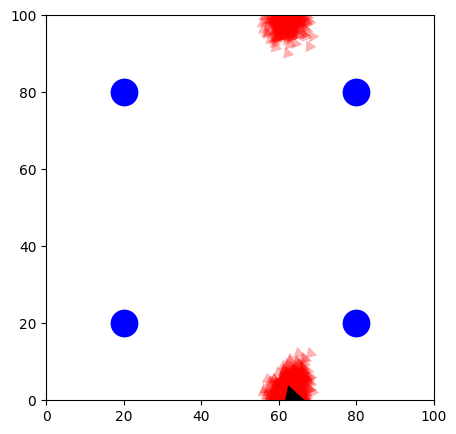

Average distance before resample: 3.924862837876861


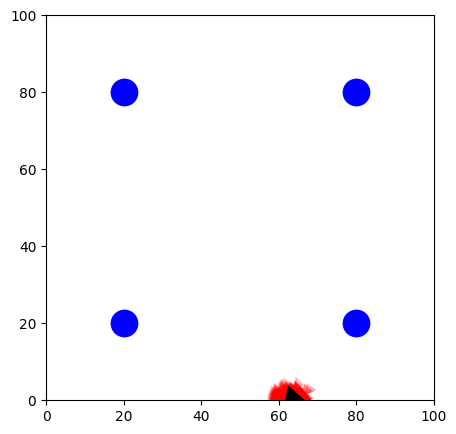

Average distance after resample: 1.754608620607875


In [17]:
for turn in range(T):
    print('\nTurn #{}'.format(turn+1))

    # real robot movement
    # turn 0.1 and move 10 meters
    myrobot = myrobot.move(0.2, 10.0)

    # elapse time
    # move particles using the same movement made by robot
    p2 = []
    for i in range(N):
        p2.append(p[i].move(0.2, 10.0))
    p = p2

    show_belief(myrobot, p)
    print("Average distance before resample:", eval(myrobot, p))

    # observe
    Z = myrobot.sense()

    # weight particles
    w = []
    for rob in p:
        prob = rob.measurement_prob(Z)
        w.append(prob)

    # resample using spinning wheel
    p2 = []
    index = int(random.random()*N)
    beta = 0
    mw = max(w)

    for i in range(N):
        beta += random.random() * 2 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1)%N
        p2.append(p[index])
    p = p2

    show_belief(myrobot, p)
    print("Average distance after resample:", eval(myrobot, p))